# Fraud Detection System - V1: Exploratory Data Analysis (EDA)

**Date:** 2026-01-24    
**Author:** *Luis Renteria Lezano*  
[LinkedIn](https://www.linkedin.com/in/renteria-luis) | [GitHub](https://github.com/renteria-luis)

## Executive Summary
- **Goal:** Understand the key factors influencing **fraudulent transactions** in credit card operations and prepare **clean, structured data** suitable for building **baseline and advanced classification models**. The focus is on **detecting anomalies**, **identifying patterns of fraud**, and creating a **robust dataset** that can support **machine learning algorithms** for **real-time fraud detection**. Special attention is given to the **highly imbalanced target class**, ensuring proper handling of **rare fraudulent cases** during model training and evaluation.
- **Source:** This analysis uses the Credit Card Fraud Detection dataset published on [Kaggle by MLG ULB](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data).
- **Data:** [`../data/raw/creditcard.csv`](../data/raw/creditcard.csv).
- **Target variable:** `Class`:
    - 0 = legitimate transaction
    - 1 = fraudulent transaction

## 1. Reproducibility & Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1. Global Reproducibility
SEED = 42
np.random.seed(SEED)

# 2. Path Management
BASE_DIR = Path("..")
DATA_RAW = BASE_DIR / "data" / "raw"
DATA_PROCESSED = BASE_DIR / "data" / "processed"
MODELS_DIR = BASE_DIR / "models"

# 3. Plotting Style
sns.set_theme(style='whitegrid', context='notebook', palette='viridis')
plt.rcParams["figure.figsize"] = (10, 6)

# 4. Global Settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 2. Data Loading & Overview
### 2.1 Load Data

In [2]:
raw_file = DATA_RAW / "creditcard.csv"
df = pd.read_csv('../data/raw/creditcard.csv')

### 2.2 Dataset Shape & Info

In [3]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Columns: 31 entries, Time to Class
dtypes: float64(30), int64(1)
memory usage: 67.4 MB


### 1.3 First Rows Preview

In [4]:
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,-0.552,-0.618,-0.991,-0.311,1.468,-0.470,0.208,0.026,0.404,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,1.613,1.065,0.489,-0.144,0.636,0.464,-0.115,-0.183,-0.146,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,0.625,0.066,0.717,-0.166,2.346,-2.890,1.110,-0.121,-2.262,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0


In [5]:
df.tail(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284804,172788.000,1.920,-0.301,-3.250,-0.558,2.631,3.031,-0.297,0.708,0.432,-0.485,0.412,0.063,-0.184,-0.511,1.329,0.141,0.314,0.396,-0.577,0.001,0.232,0.578,-0.038,0.640,0.266,-0.087,0.004,-0.027,67.880,0
284805,172788.000,-0.240,0.530,0.703,0.690,-0.378,0.624,-0.686,0.679,0.392,-0.399,-1.934,-0.963,-1.042,0.450,1.963,-0.609,0.510,1.114,2.898,0.127,0.265,0.800,-0.163,0.123,-0.569,0.547,0.109,0.105,10.000,0
284806,172792.000,-0.533,-0.190,0.703,-0.506,-0.013,-0.650,1.577,-0.415,0.486,-0.915,-1.040,-0.032,-0.188,-0.084,0.041,-0.303,-0.660,0.167,-0.256,0.383,0.261,0.643,0.377,0.009,-0.474,-0.818,-0.002,0.014,217.000,0


**Findings:**
- Features V1-V28 are PCA-transformed (anonymized for privacy purposes)
- Time: seconds elapsed since first transaction
- Amount: transaction value
- Class: 0 (legitimate) / 1 (fraud)

## 3. Data Quality Assessment
### 3.1 Missing Values

In [6]:
missing_per_col = df.isna().sum()

if missing_per_col.sum() > 0:
    missing_per_col[missing_per_col > 0].sort_values(ascending=False).head()
else:
    print('There are no missing values in the dataset.')

There are no missing values in the dataset.


### 3.2 Duplicates

In [7]:
duplicates = df.duplicated().sum()

if duplicates > 0:
    print(f'There are {duplicates} duplicated rows in the dataset.')
else:
    print('There are no duplicates in the dataset.')

There are 1081 duplicated rows in the dataset.


## 4. Target Variable Analysis (Class Imbalance)
### 4.1 Class Distribution

In [8]:
counts = df['Class'].value_counts()
percent = df['Class'].value_counts(normalize=True) * 100

summary = pd.DataFrame({
    'Count': counts,
    'Percentage': percent
}).reset_index()

summary.rename(columns={'index': 'Class'}, inplace=True)
summary

,Class,Count,Percentage
0,0,284315,99.827
1,1,492,0.173


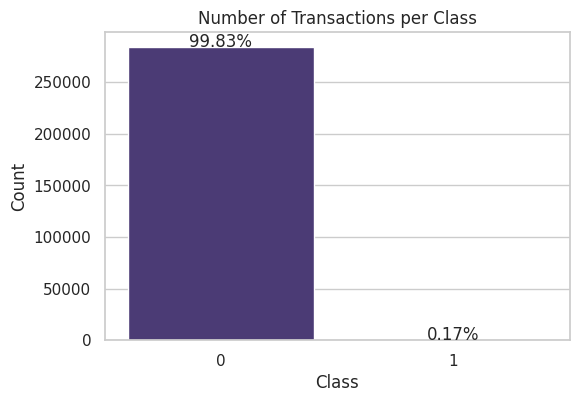

In [9]:
plt.figure(figsize=(6,4))
ax = sns.barplot(x='Class', y='Count', data=summary)
plt.title('Number of Transactions per Class')

for i, row in summary.iterrows():
    ax.text(i, row['Count'] + 100, f"{row['Percentage']:.2f}%", ha='center')

plt.show()

**Key Finding:**
- Class 0: 284,315 (99.83%)
- Class 1: 492 (0.17%)
- **Severe imbalance → will need SMOTE/class weights**

### 4.2 Imbalance Ratio

In [10]:
# imbalance_ratio = legitimate / fraud
print(f"For every fraudulent transaction, there are {int(summary.loc[0, 'Count'] / summary.loc[1, 'Count'])} legitimate transactions.")

For every fraudulent transaction, there are 577 legitimate transactions.


**Implication for modeling:**
- Accuracy is useless metric (99.8% by predicting all 0)
- Focus on Precision, Recall, F1, ROC-AUC
- Stratified split essential